## Stock-Price-Trend-Prediction-Based-on-News-DSI
--- 
The prediction of stock prices in the market has always been an important task. However, due to the market volatility, it is difficult to make the correct prediction solely based on historical stock data. Therefore in this paper, with the analysis of daily news’ impact on stock markets, we identify some key features that could be useful in stock price prediction and propose a deep learning model to capture the dynamics of stock price trend with rich news textual information.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set()
import tensorflow as tf
import io
#pd.set_option('display.max_rows', 2000)
#pd.set_option('display.max_columns', 2000)

In [ ]:
#importing test and train data
data=pd.read_csv('data.csv',index_col=0)

### Train data

In [ ]:
data.head(3)

,Open,Close,News,polarity,subjectivity,compound,neutral,positive,negative
Date,,,,,,,,,
2008-08-08,11432.08984,11734.32031,Georgia downs two Russian warplanes as countri...,-0.048568,0.267549,-0.9982,0.723,0.041,0.236
2008-08-11,11729.66992,11782.34961,Why wont America and Nato help us If they wont...,0.109325,0.374806,-0.9838,0.720,0.090,0.190
2008-08-12,11781.70020,11642.46973,Remember that adorable 9yearold who sang at th...,-0.044302,0.536234,-0.9679,0.817,0.056,0.127


---
**Training data will be feed to predict whether the price will go up(1) or down(0).**
* Our target column is price indicator
* We won't need the News column as we have already included sentiments from it in our data.


In [ ]:
#dropping news column
data=data.drop(['News'],axis=1)
data.head()

,Open,Close,polarity,subjectivity,compound,neutral,positive,negative
Date,,,,,,,,
2008-08-08,11432.08984,11734.32031,-0.048568,0.267549,-0.9982,0.723,0.041,0.236
2008-08-11,11729.66992,11782.34961,0.109325,0.374806,-0.9838,0.720,0.090,0.190
2008-08-12,11781.70020,11642.46973,-0.044302,0.536234,-0.9679,0.817,0.056,0.127
2008-08-13,11632.80957,11532.95996,0.005842,0.364021,-0.9792,0.787,0.067,0.146
2008-08-14,11532.07031,11615.92969,0.035469,0.375099,-0.9876,0.713,0.096,0.191


In [ ]:
#prepare data for training
X_train_cols=['Open','Close','polarity','subjectivity','compound','neutral','positive','negative']

from sklearn.preprocessing import MinMaxScaler
#scaling training data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data[X_train_cols])
scaled_data

array([[0.41511378, 0.4408942 , 0.4206494 , ..., 0.44444444, 0.23129252,
        0.68235294],
       [0.4404009 , 0.44497647, 0.79502434, ..., 0.43464052, 0.56462585,
        0.50196078],
       [0.44482222, 0.43308732, 0.43076567, ..., 0.75163399, 0.33333333,
        0.25490196],
       ...,
       [0.92700227, 0.9474974 , 0.66057755, ..., 0.31372549, 0.57142857,
        0.64313725],
       [0.94881899, 0.96749772, 0.56246667, ..., 0.49019608, 0.36734694,
        0.54901961],
       [0.96678972, 0.96914484, 0.4517357 , ..., 0.46078431, 0.3537415 ,
        0.59215686]])

#### Close price data for past 60 days for LSTM

In [ ]:
##Create the training dataset
import math

dataset = data.values
train_size= math.ceil(len(dataset)*.8)#training data no. of rows

train_data=scaled_data[:train_size,:]

X_train=[]
y_train=[]

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0:])
    y_train.append(train_data[i,0:])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape, y_train.shape

((1532, 60, 8), (1532, 8))

---

---
## Model 1: LSTM 

In [ ]:
# making X_train a tensor
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],8))
y_train=np.array(y_train).reshape(-1,1,8)

In [ ]:
X_train.shape, y_train.shape

((1532, 60, 8), (1532, 1, 8))

In [ ]:
#importing libraries for LSTM model
#pip install -U numpy==1.18.5

from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import classification_report

model1 = Sequential()
model1.add(LSTM(200, return_sequences=True, input_shape = (X_train.shape[1], 8)))
model1.add(LSTM(150,return_sequences=True))
model1.add(LSTM(100,return_sequences=False))
model1.add(Dense(50))
model1.add(Dense(8))

In [ ]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model1.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

epochs=1
batch_size=1

history=model1.fit(X_train, y_train, epochs = epochs, batch_size = batch_size
          ,validation_split=0.2)#, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

1225/1225 [==============================] - 46s 38ms/step - loss: 0.0158 - accuracy: 0.3518 - val_loss: 0.0141 - val_accuracy: 0.3876


### Testing data

In [ ]:
#Create the testing dataset
test_data=scaled_data[train_size-60: ,:]

#Create datasets --> x_test and y_test
X_test=[]
y_test=scaled_data[train_size: ,:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0:])

In [ ]:
X_test, y_test= np.array(X_test), np.array(y_test)
#reshaping X_tet and y_test
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],8))
y_test=np.array(y_test).reshape(-1,1,8)

#Evaluating model
accr=model1.evaluate(X_test,y_test)
print(accr)

13/13 [==============================] - 1s 39ms/step - loss: 0.0137 - accuracy: 0.4753
[0.013736042194068432, 0.4753150939941406]


The model is only 47% accurate.

---

In [ ]:
predicted_y_test = model1.predict(X_test)
predicted_y_test[0]

array([0.9469672 , 0.9318828 , 0.5716921 , 0.38958162, 0.01276489,
       0.6191705 , 0.38763753, 0.4212943 ], dtype=float32)

In [ ]:
predictions = scaler.inverse_transform(predicted_y_test) #unscaling the values

In [ ]:
train = data[:train_size]
train

,Open,Close,polarity,subjectivity,compound,neutral,positive,negative
Date,,,,,,,,
2008-08-08,11432.08984,11734.32031,-0.048568,0.267549,-0.9982,0.723,0.041,0.236
2008-08-11,11729.66992,11782.34961,0.109325,0.374806,-0.9838,0.720,0.090,0.190
2008-08-12,11781.70020,11642.46973,-0.044302,0.536234,-0.9679,0.817,0.056,0.127
2008-08-13,11632.80957,11532.95996,0.005842,0.364021,-0.9792,0.787,0.067,0.146
2008-08-14,11532.07031,11615.92969,0.035469,0.375099,-0.9876,0.713,0.096,0.191
...,...,...,...,...,...,...,...,...
2014-11-26,17812.25000,17827.75000,0.053437,0.386875,-0.9902,0.753,0.082,0.165
2014-11-28,17830.55078,17828.24023,0.051834,0.344418,-0.9957,0.753,0.066,0.180
2014-12-01,17827.26953,17776.80078,0.053924,0.420202,-0.9923,0.777,0.062,0.161


In [ ]:
test = data[train_size:]
test

,Open,Close,polarity,subjectivity,compound,neutral,positive,negative
Date,,,,,,,,
2014-12-04,17910.01953,17900.09961,-0.075678,0.430321,-0.9980,0.798,0.028,0.174
2014-12-05,17903.05078,17958.78906,-0.008315,0.259493,-0.9952,0.739,0.077,0.184
2014-12-08,17954.93945,17852.48047,-0.012152,0.307578,-0.9954,0.769,0.065,0.166
2014-12-09,17847.36914,17801.19922,0.000694,0.296065,-0.9916,0.767,0.075,0.158
2014-12-10,17797.99023,17533.15039,-0.074743,0.427416,-0.9979,0.706,0.066,0.228
...,...,...,...,...,...,...,...,...
2016-06-27,17355.21094,17140.24023,-0.014015,0.352311,-0.9644,0.758,0.094,0.148
2016-06-28,17190.50977,17409.72070,0.046560,0.352649,-0.9571,0.764,0.103,0.133
2016-06-29,17456.01953,17694.67969,0.052622,0.389617,-0.9975,0.683,0.091,0.226


In [ ]:
p_list=[] #prediction list
for i in range(len(predictions)):
    p_list.append(predictions[i][1])
    
p_list[:5]

[17510.969, 17522.479, 17563.527, 17622.63, 17685.809]

In [ ]:
#Get root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

8720.282911592853

Very high RMSE

In [ ]:
test['Predicted Price'] = 0
for i in range(len(test)):
    test['Predicted Price'][i] = p_list[i]

<ipython-input-21-8a69a816a70b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted Price'] = 0
<ipython-input-21-8a69a816a70b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted Price'][i] = p_list[i]
C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code

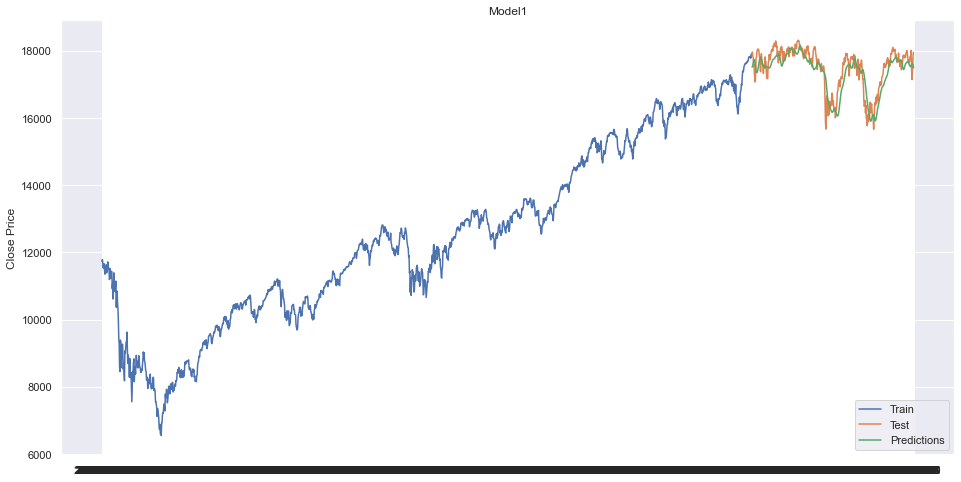

In [ ]:
#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model1')
plt.ylabel('Close Price')
plt.plot(train[['Close']])
plt.plot(test[['Close','Predicted Price']])
plt.legend(['Train','Test','Predictions'], loc='lower right')
plt.show()

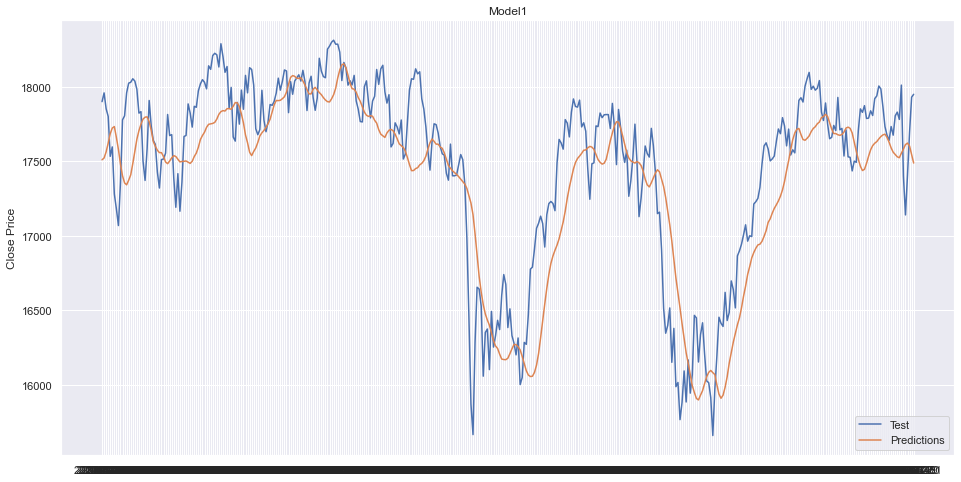

In [ ]:
#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model1')
plt.ylabel('Close Price')
plt.plot(test[['Close','Predicted Price']])
plt.legend(['Test','Predictions'], loc='lower right')
plt.show()

In [ ]:
test[['Close','Predicted Price']]

,Close,Predicted Price
Date,,
2014-12-04,17900.09961,17510
2014-12-05,17958.78906,17522
2014-12-08,17852.48047,17563
2014-12-09,17801.19922,17622
2014-12-10,17533.15039,17685
...,...,...
2016-06-27,17140.24023,17612
2016-06-28,17409.72070,17622
2016-06-29,17694.67969,17602


In [ ]:
test['Predicted Price Indicator'] = 0
for i in range(len(test)):
    if (test['Close'][i] > test['Predicted Price'][i]):
        test['Predicted Price Indicator'][i] = 0 #price down
    else:
        test['Predicted Price Indicator'][i] = 1 #price up

<ipython-input-25-ffbe03f6dce6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted Price Indicator'] = 0
<ipython-input-25-ffbe03f6dce6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted Price Indicator'][i] = 0 #price down
C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [ ]:
test[['Close','Predicted Price','Predicted Price Indicator']]

,Close,Predicted Price,Predicted Price Indicator
Date,,,
2014-12-04,17900.09961,17510,0
2014-12-05,17958.78906,17522,0
2014-12-08,17852.48047,17563,0
2014-12-09,17801.19922,17622,0
2014-12-10,17533.15039,17685,1
...,...,...,...
2016-06-27,17140.24023,17612,1
2016-06-28,17409.72070,17622,1
2016-06-29,17694.67969,17602,0


---
## Model 2: ARIMA

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

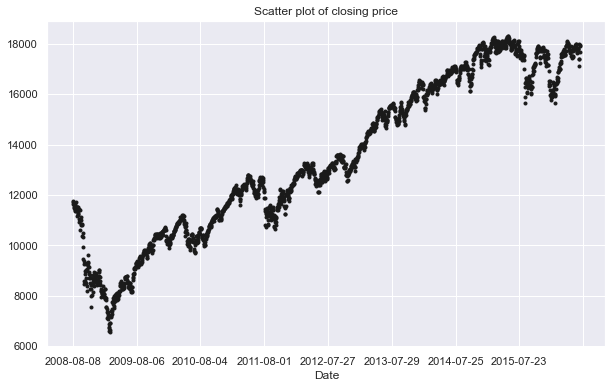

In [ ]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

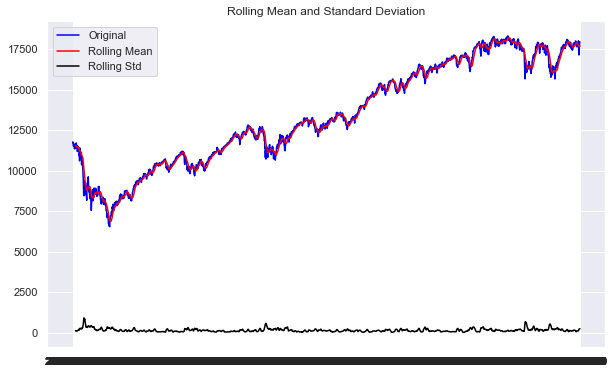

Results of dickey fuller test
Test Statistics                  -0.374713
p-value                           0.914236
No. of lags used                 20.000000
Number of observations used    1968.000000
critical value (1%)              -3.433677
critical value (5%)              -2.863010
critical value (10%)             -2.567552
dtype: float64


In [ ]:
#Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to **separate seasonality** and trend from our series. The resultant series will become stationary through this process.

<Figure size 1152x648 with 0 Axes>

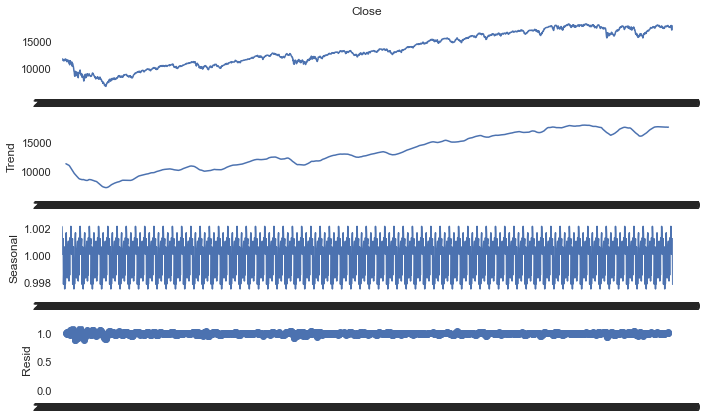

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure(figsize=(16,9))  
fig = result.plot()  
plt.show()

Reducing the rising trend in the series by taking a log of the series.

No handles with labels found to put in legend.


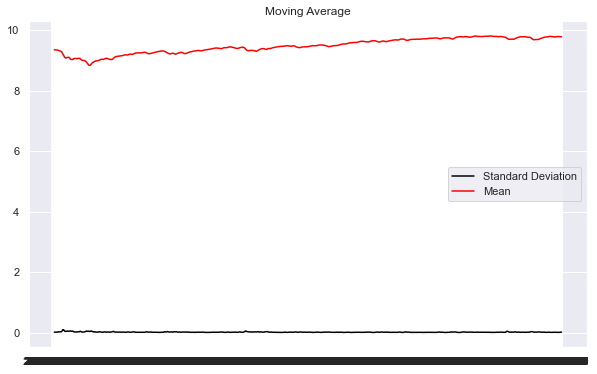

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

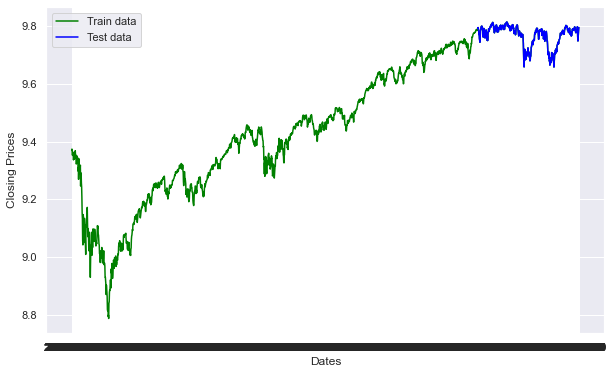

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

#### Model

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11628.008, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9222.141, Time=0.79 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-9220.867, Time=1.00 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-9216.033, Time=1.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9227.829, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2316.058, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-9222.947, Time=1.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-9230.154, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3978.174, Ti

So the Auto ARIMA model provided the value of p,d, and q as 1,0 and 3 respectively. And the model to ne used is SARIMAX.

The best model SARIMAX(1,0,3) has an AIC of 528.6 and the P Values are significant.

C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


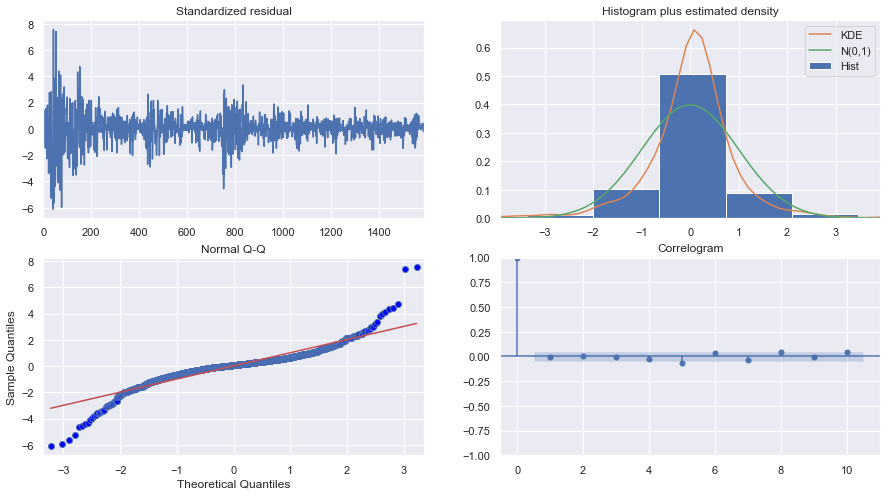

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.


In [ ]:
model = SARIMAX(train_data, order=(1,0,3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1588
Model:               SARIMAX(1, 0, 3)   Log Likelihood                4616.808
Date:                Mon, 21 Jun 2021   AIC                          -9223.616
Time:                        18:35:49   BIC                          -9196.765
Sample:                             0   HQIC                         -9213.642
                               - 1588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.94e-06   5.15e+05      0.000       1.000       1.000
ma.L1         -0.1355      0.015     -9.164      0.000      -0.164      -0.106
ma.L2         -0.0279      0.012     -2.404      0.0

C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


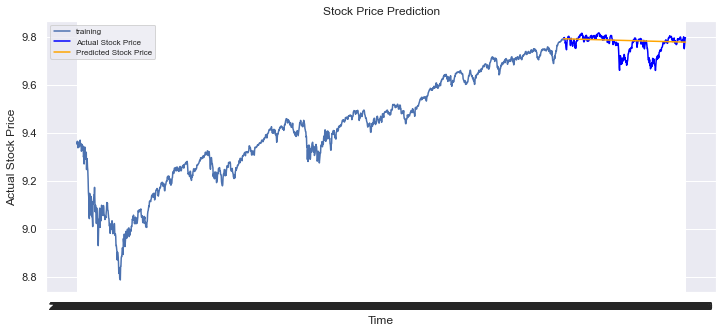

In [ ]:
# Forecast
fc= fitted.forecast(len(test_data), alpha=0.05)  # 95% confidence
fc_series=pd.DataFrame(fc)
fc_series['Date']=list(test_data.index)
fc_series.set_index('Date', drop=True, inplace=True)

plt.figure(figsize=(12,5))
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: ',mse)
mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE:  0.001474261472687624
MAE:  0.025327653159186156
RMSE: 0.038396112728863896


---

Of the above models, **LSTM seems to predict better**, derived by observing the graphs. So, saving LSTM model for future use.

### Saving LSTM model

In [ ]:
import tensorflow as tf

model1.save('stock_news_prediction.h5')

---